In [13]:
from collections import defaultdict

import cv2
import matplotlib as mpl
import pandas as pd
from gabriel_lego.cv.lego_cv import LowConfidenceError, LEGOCVError, NoLEGODetectedError, NoBoardDetectedError
from matplotlib import pyplot as plt
import numpy as np
from gabriel_lego.lego_engine.board import BoardState
from gabriel_lego.cv import image_util as imutil
from tqdm.notebook import tqdm
import time
import seaborn as sns
sns.set_context('notebook')

In [14]:
target_state = np.array([[0, 5, 5, 5, 0, 0],
                         [3, 4, 4, 3, 3, 2],
                         [4, 4, 4, 4, 4, 4]], dtype=np.uint8)
board = BoardState(target_state)
board.bitmap

array([[0, 5, 5, 5, 0, 0],
       [3, 4, 4, 3, 3, 2],
       [4, 4, 4, 4, 4, 4]], dtype=uint8)

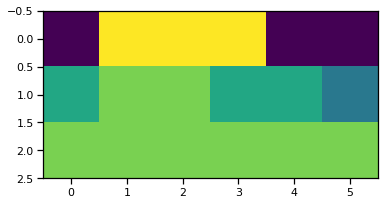

In [15]:
plt.imshow(board.bitmap)
plt.show()

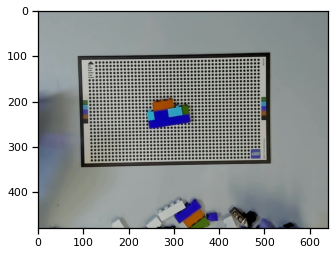

array([[[  0,   1,   2],
        [  0,   0,   1],
        [  0,   2,   3],
        ...,
        [  0,   0,   1],
        [  0,   0,   1],
        [  0,   0,   1]],

       [[  0,   0,   1],
        [154, 158, 159],
        [151, 155, 156],
        ...,
        [129, 134, 135],
        [130, 135, 136],
        [130, 135, 136]],

       [[  0,   0,   1],
        [155, 160, 161],
        [154, 159, 160],
        ...,
        [127, 135, 135],
        [128, 136, 136],
        [128, 136, 136]],

       ...,

       [[  0,   1,   0],
        [111, 114, 112],
        [111, 117, 112],
        ...,
        [138, 142, 131],
        [138, 142, 131],
        [138, 142, 131]],

       [[  0,   1,   0],
        [109, 114, 112],
        [110, 116, 111],
        ...,
        [138, 142, 131],
        [138, 142, 131],
        [138, 142, 131]],

       [[  0,   1,   0],
        [109, 114, 112],
        [110, 116, 111],
        ...,
        [138, 142, 131],
        [138, 142, 131],
        [138, 142, 131]]

In [16]:
# corresponding success frame
success_img = cv2.imread('./success_frame.jpeg', cv2.IMREAD_UNCHANGED)
plt.imshow(success_img)
plt.show()
success_img

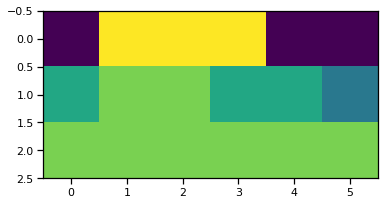

In [17]:
# make sure image matches board
success_board = imutil.preprocess_img(success_img)
success_board = BoardState(success_board)

assert success_board == board

plt.imshow(success_board.bitmap)
plt.show()

In [18]:
# add noise
rng = np.random.default_rng()
frame_cats = defaultdict(list)

for i in tqdm(range(1, 255), desc='Generating "real" frames...'):
    max_arr_val = 255 - i
    frame = success_img.copy()
    frame[frame > max_arr_val] = 255
    frame[frame <= max_arr_val] += i

    try:
        lc_frame = imutil.preprocess_img(frame)
        continue
    except Exception as e:
        frame_cats[type(e).__name__].append(frame)

# generate some noise
for i in tqdm(range(50), desc='Noise'):
    frame_cats['Noise'].append(rng.integers(256, dtype=np.uint8, size=success_img.shape))

frame_cats['Success'].append(success_img)

{
    c: len(f) for c, f in frame_cats.items()
}

    # cv2.putText(
    #     img=frame,
    #     text=f'{i}: {error}',
    #     color=(0, 0, 255),
    #     org=(20, 40),
    #     fontFace=cv2.FONT_HERSHEY_PLAIN,
    #     fontScale=2,
    #     thickness=1
    # )
    # plt.imshow(frame)
    # plt.show()

Generating "real" frames...:   0%|          | 0/254 [00:00<?, ?it/s]

Noise:   0%|          | 0/50 [00:00<?, ?it/s]

{'LowConfidenceError': 35,
 'NoBoardDetectedError': 95,
 'LEGOCVError': 52,
 'Noise': 50,
 'Success': 1}

In [19]:
# benchmark
num_samples = 200
results = pd.DataFrame(index=range(num_samples), columns=frame_cats.keys())

for cat, frames in tqdm(frame_cats.items(), desc='Frame categories'):
    ptimes = np.empty(num_samples, dtype=np.float64)
    for i in tqdm(range(num_samples), desc=cat):
        ti = time.monotonic()
        try:
            imutil.preprocess_img(rng.choice(frames))
        except (LowConfidenceError, LEGOCVError):
            pass
        ptimes[i] = time.monotonic() - ti

    results.loc[:, cat] = ptimes


results

Frame categories:   0%|          | 0/5 [00:00<?, ?it/s]

LowConfidenceError:   0%|          | 0/200 [00:00<?, ?it/s]

NoBoardDetectedError:   0%|          | 0/200 [00:00<?, ?it/s]

LEGOCVError:   0%|          | 0/200 [00:00<?, ?it/s]

Noise:   0%|          | 0/200 [00:00<?, ?it/s]

Success:   0%|          | 0/200 [00:00<?, ?it/s]

,LowConfidenceError,NoBoardDetectedError,LEGOCVError,Noise,Success
0,0.216758,0.060855,0.029935,0.092953,0.225070
1,0.195965,0.020809,0.007042,0.085314,0.194082
2,0.208283,0.022516,0.006351,0.088535,0.185670
3,0.203625,0.033223,0.005221,0.080670,0.189831
4,0.193338,0.023036,0.005112,0.081982,0.220493
...,...,...,...,...,...
195,0.197941,0.020477,0.005742,0.084398,0.191685
196,0.194680,0.019748,0.006599,0.081499,0.193477
197,0.192010,0.023644,0.004051,0.085015,0.187125
198,0.198459,0.021711,0.004346,0.083642,0.188176


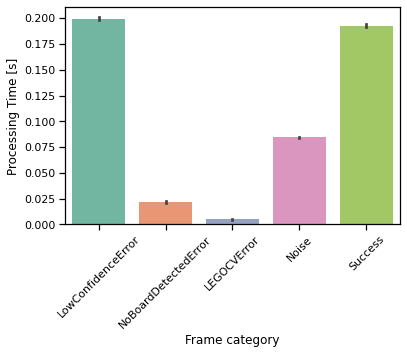

In [20]:
with sns.color_palette('Set2'):
    ax = sns.barplot(
        data=results
            .stack()
            .reset_index()
            .drop(columns=['level_0'])
            .rename(columns={'level_1': 'category', 0: 'time'}),
        x='category',
        y='time',
        ci=95
    )
    ax.set_xlabel('Frame category')
    ax.set_ylabel('Processing Time [s]')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.show()

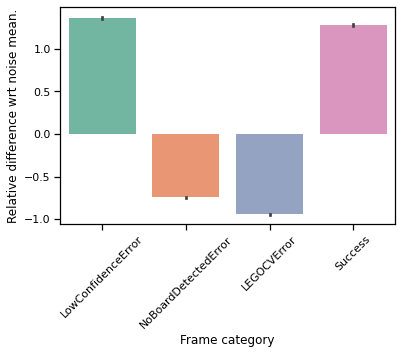

In [21]:
df = results.copy()
noise_mean = df['Noise'].mean()
df = df.drop(columns=['Noise'])
for col in df.columns:
    df[col] = (df[col] - noise_mean) / noise_mean

with sns.color_palette('Set2'):
    ax = sns.barplot(
        data=df
            .stack()
            .reset_index()
            .drop(columns=['level_0'])
            .rename(columns={'level_1': 'category', 0: 'time'}),
        x='category',
        y='time',
        ci=95
    )
    ax.set_xlabel('Frame category')
    ax.set_ylabel('Relative difference wrt noise mean.')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.show()

del df